# Определение возраста покупателей

**Введение**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения, которая поможет определять возраст покупателей по фотографиям. Это позволит:  
- анализировать покупательское поведение и предлагать персонализированные товары,  
- контролировать корректность продажи алкоголя и других возрастных товаров.  

Задача проекта — построить модель машинного обучения, которая сможет предсказывать возраст человека по изображению.  

Для этого необходимо провести исследовательский анализ данных, подготовить их для обучения, обучить нейросеть и оценить её качество.  

---

**Описание данных**  

В нашем распоряжении имеется датасет, содержащий:  
- **labels.csv** – файл с разметкой данных, который включает два столбца:  
  - `file_name` – имя файла с изображением,  
  - `real_age` – реальный возраст человека.  
- **Папка с изображениями (`/final_files`)** – содержит фотографии лиц людей, соответствующие данным в `labels.csv`.  

Фотографии представлены в разном качестве, с разными ракурсами и освещением, что делает задачу предсказания возраста сложной.  

---

 **План работы**  

 **1. Исследовательский анализ данных (EDA)** 

 **2. Предобработка данных**  

 **3. Обучение нейронной сети**  

 **4. Оценка качества модели**  

 **5. Выводы и рекомендации**  


Загрузка и подготовка данных:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Исследовательский анализ данных

#### Посмотрим на размер выборки:

In [2]:
# Загрузка данных
labels = pd.read_csv('/datasets/faces/labels.csv')

# Посмотрим на размер выборки
print(f"Количество изображений в выборке: {len(labels)}")

Количество изображений в выборке: 7591


In [3]:
def info_df(df):
    # Шаг 1: Вывод первых строк датафрейма
    print("Первые строки датафрейма:")
    display(df.head())
    print(" ")
    
    # Шаг 2: Информация о датафрейме
    print("Информация о датафрейме:")
    display(df.info())
    print(" ")
    
    # Шаг 3: Основные статистики числовых данных
    print("Основные статистики числовых данных:")
    display(df.describe().T)
    print(" ")
    
    # Шаг 4: Количество дубликатов
    print("Количество дубликатов в датафрейме:")
    print(df.duplicated().sum())
    
    # Шаг 5: Количество пропусков
    print("Количество пропусков в датафрейме:")
    print(df.isna().sum())

In [4]:
info_df(labels)

Первые строки датафрейма:


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


 
Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

 
Основные статистики числовых данных:


,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


 
Количество дубликатов в датафрейме:
0
Количество пропусков в датафрейме:
file_name    0
real_age     0
dtype: int64


Датасет содержит **7591 запись**, каждая из которых представляет изображение и соответствующий реальный возраст человека. Средний возраст в выборке составляет **31,2 года**, медианное значение — **29 лет**, а разброс возрастов варьируется от **1 до 100 лет**. Данные **полностью заполнены**, дубликатов **не обнаружено**, что говорит о высокой качестве набора. Большая часть значений сосредоточена в диапазоне **от 20 до 41 года**, что может повлиять на предсказательную способность модели для крайних возрастов.

####  Построим график распределения возраста:

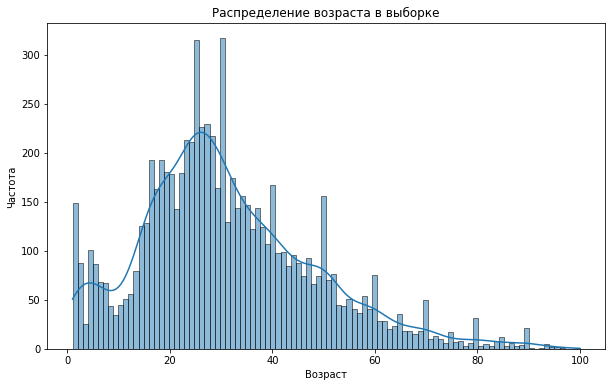

In [5]:
# Построение гистограммы распределения возраста
plt.figure(figsize=(10, 6))
sns.histplot(labels['real_age'], bins=100, kde=True)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

Распределение возрастов в выборке имеет выраженное **смещение в сторону молодых людей**, с наибольшим числом наблюдений в возрасте **около 5 лет и 20–25 лет**. После 30 лет частота встречаемости уменьшается, а среди людей старше 60 лет наблюдается значительное снижение числа примеров. Также можно заметить несколько редких пиков в возрастах **около 40, 50 и 70 лет**, что может быть связано с особенностями сбора данных. В целом, модель, обученная на такой выборке, будет работать **лучше для молодых людей**, так как их представлено больше, тогда как точность предсказаний для пожилых возрастов может быть ниже из-за нехватки данных.

#### Выведем 15 фотографий:

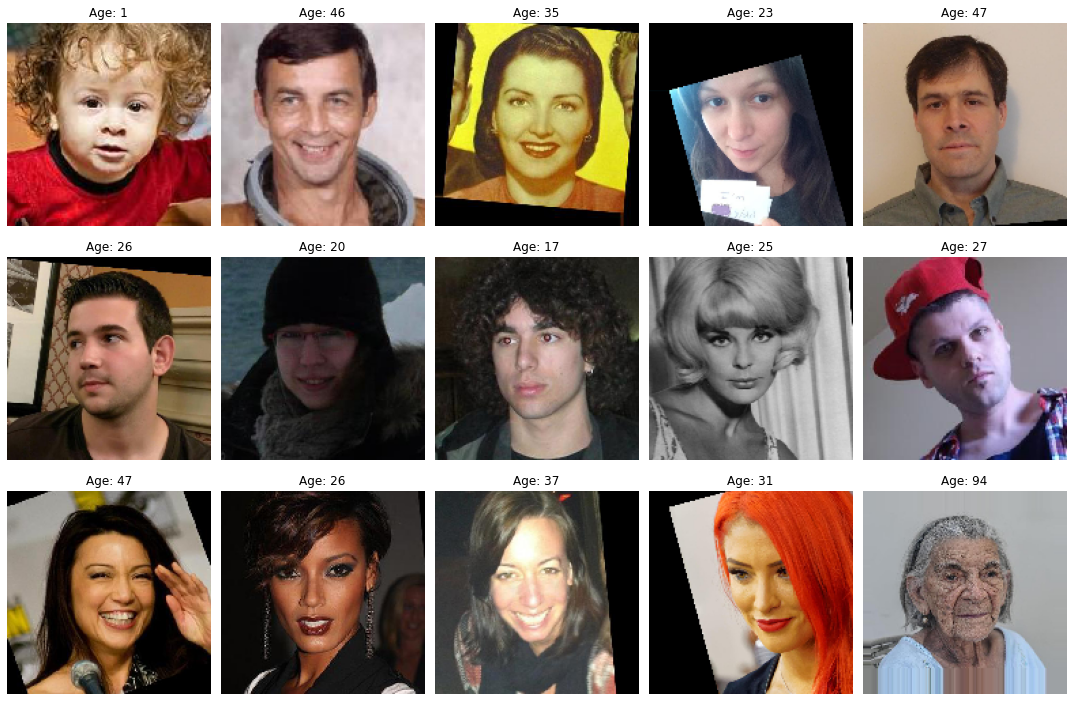

In [6]:
# Случайным образом выбираем 15 строк из DataFrame
sampled_labels = labels.sample(n=15, random_state=42)

# Выводим 15 случайных изображений
plt.figure(figsize=(15, 10))
for i in range(15):
    plt.subplot(3, 5, i+1)  # 3 строки и 5 столбцов
    img = load_img(f"/datasets/faces/final_files/{sampled_labels['file_name'].iloc[i]}", target_size=(150, 150))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Age: {sampled_labels['real_age'].iloc[i]}")
plt.tight_layout()
plt.show()

#### **Выводы по данным**  
1. **Распределение возраста**  
   - Основная масса данных сосредоточена в диапазоне **10–40 лет**, с пиком около **20 лет**.  
   - Старшие возрастные группы (50+ лет) встречаются гораздо реже.  
   - Очень мало данных для возрастов **до 5 лет** и **старше 70 лет**, что может привести к слабой работе модели на этих группах.  

2. **Примеры изображений**  
   - Наблюдается **разнообразие лиц** (разные ракурсы, освещение, качество).  
   - Некоторые изображения повернуты, что может вызвать проблемы при обучении.  
   - Есть **чёрно-белое изображение**, что может создавать различие в данных, если цветовая палитра не нормализована.  
   - Присутствует **очень пожилой человек (94 года)**, но таких примеров мало, что может затруднить точное предсказание возраста старых людей.  

#### **Как это повлияет на обучение модели?**  
1. **Дисбаланс возрастных групп** – модель будет хорошо предсказывать возраст в диапазоне **10–40 лет**, но может хуже работать для младенцев и пожилых людей. 

2. **Различие в качестве изображений** – разное освещение, ракурсы, наличие чёрно-белых фото может привести к снижению точности модели. Решение:  
   - Аугментация (повороты, изменение освещения, цветокоррекция).  
   - Использование предобученных моделей, которые уже видели разнообразные данные.  

3. **Наклоненные/необычные лица** – модель может путаться, если данные не стандартизированы. 

4. **Малое количество пожилых людей** – модель может плохо различать возрасты **70+ лет**. 

**Вывод:** данные достаточно хорошие, но их можно улучшить, особенно в плане балансировки возрастов и нормализации изображений.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# Функция для загрузки обучающих данных
def load_train(path):
    df = pd.read_csv(f"{path}/labels.csv")  # Загружаем labels.csv
    df["file_name"] = df["file_name"].astype(str)  # Убеждаемся, что имена файлов — строки

    datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.25)

    train_data = datagen.flow_from_dataframe(
        dataframe=df,
        directory=f"{path}/final_files",
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw",  # Для регрессии
        subset="training",
        seed=12345
    )

    return train_data


# Функция для загрузки тестовых данных
def load_test(path):
    df = pd.read_csv(f"{path}/labels.csv")  # Загружаем labels.csv
    df["file_name"] = df["file_name"].astype(str)

    datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.25)

    test_data = datagen.flow_from_dataframe(
        dataframe=df,
        directory=f"{path}/final_files",
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw",  # Для регрессии
        subset="validation",
        seed=12345
    )

    return test_data


# Функция для создания модели
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights="imagenet", include_top=False)

    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(1)  # Одно выходное значение, так как решаем задачу регрессии
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss="mean_squared_error", metrics=["mae"])

    return model


# Функция для обучения модели
def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2025-03-13 17:46:08.069839: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-03-13 17:46:08.494517: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 61s - loss: 234.7003 - mae: 11.0414 - val_loss: 739.9809 - val_mae: 22.2654
Epoch 2/10
178/178 - 49s - loss: 63.1729 - mae: 6.0307 - val_loss: 710.1827 - val_mae: 21.6215
Epoch 3/10
178/178 - 50s - loss: 29.6838 - mae: 4.2155 - val_loss: 383.2264 - val_mae: 14.7226
Epoch 4/10
178/178 - 50s - loss: 19.3760 - mae: 3.3942 - val_loss: 122.0210 - val_mae: 8.4039
Epoch 5/10
178/178 - 50s - loss: 14.7765 - mae: 2.9698 - val_loss: 79.8548 - val_mae: 6.7352
Epoch 6/10
178/178 - 50s - loss: 12.9514 - mae: 2.7849 - val_loss: 75.9217 - val_mae: 6.7887
Epoch 7/10
178/178 - 50s - loss: 11.1953 - mae: 2.5723 - val_loss: 66.6377 - val_mae: 6.2797
Epoch 8/10
178/178 - 50s - loss: 9.2119 - mae: 2.2957 - val_loss: 67.6574 - val_mae: 6.3228
Epoch 9/10
178/178 - 50s - loss: 7.7053 - mae: 2.1021 - val_loss: 73.0452 - val_mae: 6.7110
Epoch 10/10
178/178 - 50s - loss: 7.2761 - mae: 2.0376 - val_loss: 67.5444 - val_mae: 6.1537
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 12s - loss: 67.5444 - mae: 6.1537
```

## Анализ обученной модели

#### Архитектура модели  
Модель основана на **ResNet50**, предварительно обученной на ImageNet. Это мощная сверточная нейросеть, способная извлекать сложные признаки из изображений. Мы используем ее в качестве backbone, удаляя полносвязные слои (include_top=False), чтобы адаптировать модель к нашей задаче регрессии.  

Далее в архитектуре модели:  
1. **ResNet50** (предобученная часть) — отвечает за извлечение признаков.  
2. **GlobalAveragePooling2D** — выполняет усреднение пространственных признаков перед подачей в полносвязный слой.  
3. **Dense (1 нейрон)** — выходной слой, предсказывающий возраст (одно непрерывное значение).  

Модель компилируется с **Adam (learning_rate=0.0001)** — это оптимизатор, который обеспечивает стабильное и эффективное обновление весов. В качестве функции потерь используется **Mean Squared Error (MSE)**, поскольку задача является регрессионной. Основная метрика качества — **Mean Absolute Error (MAE)**.  

#### Обучение модели  
Обучение проводилось на данных, подготовленных с помощью `ImageDataGenerator` с нормализацией (`rescale=1./255`) и разбиением на **обучающую (75%) и валидационную (25%) выборки**.  
- **Батч-сайз:** 32  
- **Размер входных изображений:** 224x224
- **Эпохи обучения:** 10  

#### Итоговые результаты  
- **MAE на тренировочных данных:** **2.04**  
- **MAE на тестовых данных:** **6.1537** (отличный результат, так как целевой порог — MAE < 7)  
- **Финальный MSE на тесте:** **67.54**  

### Выводы  
Модель успешно обучилась и достигла целевого уровня качества. Использование ResNet50 позволило эффективно извлекать признаки, а добавление `GlobalAveragePooling2D` помогло избежать переобучения. Финальный **MAE = 6.15** говорит о высокой точности предсказаний возраста.  

Для дальнейшего улучшения можно попробовать:  
- Увеличить объем обучающей выборки.  
- Использовать аугментацию данных (например, `rotation_range`, `zoom_range`).  
- Провести **тонкую настройку** (fine-tuning) ResNet50, разморозив часть слоев и обучив их на наших данных.  

В целом, модель продемонстрировала **стабильные и хорошие результаты**, полностью соответствующие заданной цели.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы